<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S35_vacuum_decision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
import gtsam
import pandas as pd

import gtbook
import gtbook.display
from gtbook import vacuum
from gtbook.discrete import Variables
VARIABLES = Variables()
def pretty(obj): 
    return gtbook.display.pretty(obj, VARIABLES)
def show(obj, **kwargs): 
    return gtbook.display.show(obj, VARIABLES, **kwargs)

# From section 3.2:
N = 5
X = VARIABLES.discrete_series("X", range(1, N+1), vacuum.rooms)
A = VARIABLES.discrete_series("A", range(1, N), vacuum.action_space)

# Markov Decision Processes

> For controlled Markov chains, planning is the process of choosing the control inputs. This leads to
the concept of Markov decision processes (MDPs).



In [20]:
from gtbook.display import randomImages
from IPython.display import display
display(randomImages(3, 5, "steampunk", 1))

Previously in this chapter, we described how conditional probability distributions can be used to model uncertainty
in the effects of actions. We defined the belief state $b_{t+1}$ to be the posterior probability distribution
for the state at time $t+1$ given the sequence of actions $a_1 \dots a_t$.
In every example, the sequence of actions was predetermined, and we merely calculated probabilities
associated with performing these actions from some specified initial state, described
by a probability distribution $P(X_1)$.

In this chapter, we consider the problem of choosing which actions to execute.
Making these decisions requires that we have quantitative criteria for evaluating actions and their effects.
We encode these criteria using *reward functions*.
Because the effects of actions are uncertain, it is not possible to know the reward
that will be obtained by executing a specific action (or a sequence of actions). Thus, we will again
invoke the concept of expectation to compute expected future benefits of applying actions.

As we work through these concepts, it will rapidly become apparent that executing a predefined sequence of actions
is not the best way to face the future.
Suppose, for example, that our vacuuming robot wants to move from the office to the living room.
Because it is not possible to know how many times we should execute the move right action
to arrive to the hallway, we might construct a sequence of actions
to move right many times (to increase the probability of arriving to the dining room),
then move up many times (to increase the probability of arriving to the kitchen),
then move left many times (to increase the probability of arriving to the living room).

This kind of plan might make sense if the robot is unable to know its current location.
For example, moving for a long time to the right should eventually bring the robot to the dining room with
high probability,
but if the robot moves to the right for a short time, it could remain in the office,
arrive to the hallway, or arrive to the dining room.

In contrast, if the robot is able to know its location (using perception), it can act
opportunistically when it reaches the hallway, and immediately move up.
The key idea here is that the optimal action at any moment in time depends
on the state in which the action is executed.
The recipe of which action to execute in each state is called a *policy*,
and determining optimal policies is the main goal for this section.

## Reward Functions

> Stochastic actions plus a reward make an MDP.

How should our robot evaluate the effects of actions?
One simple approach might be to specify the robot's goal, and then determine
how effective an action might be with respect to that goal,
e.g., by using the conditional probability tables for the various actions.
If, for example, the goal is to arrive to the living room, we could evaluate
the probability that a particular action would achieve the goal.

The approach above has several limitations.  First, if the robot is not currently in a room
that is adjacent to the living room, it is not clear how to measure the possible progress
toward the living room for a specific action.
If, for example, the robot is in the dining room, would it be better to move
to the kitchen or to the hallway as an intermediate step toward the living room?
Second, this approach does not allow the robot to consider
benefits that could arise from visiting other states.
For example, even though the living room is the goal, arriving to the kitchen might not be
such a bad outcome, if for example, the kitchen floor is also in need of cleaning.
Finally, it may be the case that the benefit of executing an action depends
not only on the destination, but also on the state in which the action
is executed.
For example, entering the living room from the hallway might be less desirable
than entering from the kitchen (if, for example, guests are likely to arrive
in the entrance hallway).

Reward functions provide a very general solution that addresses all of these limitation.
Let $\cal X$ denote the set of states and $\cal A$ the set of actions.
The reward function, $R : {\cal X} \times {\cal A} \times {\cal X} \rightarrow \mathbb{R}$,
assigns a numeric reward to specific state transitions under specific actions.
In particular, $R(x_t, a_t, x_{t+1})$ is the reward obtained by arriving to state
$x_{t+1}$ from state $x_t$ as a result of executing action $a_t$.

In what follows we assume that the reward function is time-invariant, i.e., the benefit of moving up from
the hallway to the living room does not change as time passes.
This allows us to use the more compact notation
$R(x, a, x')$ to represent the award obtained by arriving to (the next) state $x'$
by executing action $a$ in state $x$. We will frequently use this notation in the remainder of the section.

This form for the reward function is very general, allowing us to encode context dependent rewards
that depend on the state in which an action is executed.
It is also common to specify rewards merely as a function of state.
In this case, we denote by $R(x)$ the reward obtained for arriving to state $x$, regardless
of the action that was applied, and regardless of the previous state.
An example of such a reward function is given below, implemented as a python function.
It simply returns a reward of 10 upon entering the living room:

In [21]:
def reward_function(state:int, action:int, next_state:int):
    """Reward that returns 10 upon entering the living room."""
    return 10.0 if next_state == "Living Room" else 0.0

print(reward_function("Kitchen", "L", "Living Room"))
print(reward_function("Kitchen", "L", "Kitchen"))

10.0
0.0


## Expected Reward

> Maximizing immediate expected reward leads to greedy planning.

Because the effects of actions are uncertain,
there is no way for the robot to know definitively the reward that it will obtain
by executing a specific action $a$ in state $x$.
In this case, we can use the **expected reward** as a surrogate.
As we have seen in the previous chapter, this expectation will provide a good 
estimate of the average reward that will be received if action $a$ is executed from state $x$ may times,
even if it provides no guarantees about the reward that will be obtained by any specific moment in time.

We denote the expected reward for executing action $a$ in state $x$
by $\bar{R}(x,a)$,
and its value is obtained by evaluating the expectation

$$
\bar{R}(x,a) \doteq E[R(x,a,X')] = \sum_{x'} P(x'|x,a) R(x, a, x')
$$

Note that we use the upper case $X'$ to indicate that the expectation is taken with
respect to the random next state.
Accordingly, the sum is over all possible next states, and the reward for each next
state is weighted by the probability of arriving to that state from state $x$ by executing action $a$.

<!-- In some cases (e.g., when the transition probabilities are *known*),
it can be convenient to work only with the expected reward, instead of dealing wit $R(x,a,x')$
which some texts do. However, below we will continue to work with the most general formulation. -->

To *calculate* the expected reward in code, it would be nice to rely on functions that do string compares, which is not very efficient. Since states and actions are finite (and of low cardinality), we can create a multidimensional array $R(x,a,x')$ that the rewards for every possible transition $x,a \rightarrow x'$. We use the handy GTSAM `enumerate` method below to do so:

In [57]:
conditional = gtsam.DiscreteConditional((2,5), [(0,5), (1,4)], vacuum.action_spec)
R = np.empty((5, 4, 5), float)
for assignment, _ in conditional.enumerate():
    x, a, y = assignment[0], assignment[1], assignment[2]
    R[x, a, y] = 10.0 if y == vacuum.rooms.index("Living Room") else 0.0

# For example, taking action "L" in "Kitchen":
R[vacuum.rooms.index("Kitchen"), vacuum.action_space.index("L")]

array([10.,  0.,  0.,  0.,  0.])

The result above is simple to interpret: if the robot
arrives to the living room (index 0) the robot obtains a reward of 10, otherwise 0. 

Note that $R$ is a *multidimensional* array, with shape $(5, 4, 5)$, corresponding to the dimensionality of the arguments of the reward function $R(x,a,x')$.
We can do the same with the transition probabilities, creating a multidimensional array $T$ with an entry for every possible transition $x \rightarrow a \rightarrow x'$ with probability $P(x'|a,x)$:

In [60]:
T = np.empty((5, 4, 5), float)
for assignment, P_y_given_ax in conditional.enumerate():
    x, a, y = assignment[0], assignment[1], assignment[2]
    T[x, a, y] = P_y_given_ax

# For example, taking action "L" in "Kitchen":
T[vacuum.rooms.index("Kitchen"), vacuum.action_space.index("L")]

array([0.8, 0.2, 0. , 0. , 0. ])

As expected, we end up in the living room with 80% chance, while staying in place (the Kitchen) 20% of the time.

Then, finally, calculating the expected reward $\bar{R}(x,a)$ for a particular state-action pair $(x,a)$ becomes a simple dot product:

In [63]:
x, a = vacuum.rooms.index("Kitchen"), vacuum.action_space.index("L")
print(f"Expected reward (Kitchen, L) = {np.dot(T[x,a], R[x,a])}")

Expected reward (Kitchen, L) = 8.0


This makes total sense: if we stay in the kitchen, we get zero reward, but *if* we succeed to move to the living room, we receive a reward of 10. This happens only in 80% of the cases, though, so the *expected reward* is only 8.

<!-- Note that this computation can also be realized using belief states.  In
particular, if encode the reward function as a vector (as above),
say $R = [10, 0, 0, 0, 0]^T$,
the the expected reward at time $t+1$ is given by

$$E[ R(X_t, a, X_{t+t})] = b_{t+1} R = \left( b_t M_{a}\right) R
$$

in which $M_{a}$ denotes the transition probability matrix associated
to action $ a$. Note that in this case, we the expected reward is computed for a given
prior distribution on $X_t$. If we know with certainty that $X_t =x$, the belief
vector would have a $1$ in the entry corresponding to the current room, and zero's for
all other entries.
Therefore, this form is somewhat more general than that given above. -->

Equipped with the definition of expected reward, we can introduce a first, **greedy planning** algorithm:
Given the current belief state $b_t$, execute the action that maximizes the expected reward:

$$
a^* = \arg  \max_{a \in {\cal A}} E[ R(X_t, a, X_{t+t})]
$$

 <!-- = \arg \max_{a \in {\cal A}}\left( b_t M_{A}\right) R -->

For example, in the "Kitchen", we can calculate the expected award for all actions:

In [64]:
x = vacuum.rooms.index("Kitchen")
for a in range(4):
    print(f"Expected reward ({vacuum.rooms[x]}, {vacuum.action_space[a]}) = {np.dot(T[x,a], R[x,a])}")

Expected reward (Kitchen, L) = 8.0
Expected reward (Kitchen, R) = 0.0
Expected reward (Kitchen, U) = 0.0
Expected reward (Kitchen, D) = 0.0


It turns out that $8.0$ is the best we can do by greedily choosing a single action, as the expected *immediate* reward for any other action is zero. Hence, whenever we find ourselves in the Kitchen, a good course of action is to always go left!

## Utility for a Defined Sequence of Actions

> Utility is the total discounted award over finite or infinite horizons.

The greedy strategy above focuses on the immediate benefit of applying an action.
For our robot, and for most robots operating in the real world, it is important to perform
effectively over a prolonged period of time, not merely for the next instant.
In order to maximize long-term benefit, instead of considering only the next-stage reward (as the greedy strategy does)
we could consider the sum of all rewards achieved in the future.
There are two immediate disadvantages to a direct implementation of this approach:

- First, because the effects of actions are uncertain, it is likely that the further we look
into the future, the more uncertain we will be about the robot's anticipated state.
Therefore, it makes sense to discount our consideration of rewards that might occur far into the future,
say at times $X_{t+T}$, for increasing values of $T$.

- Second, it is often convenient to reason with an infinite time horizon, e.g., consider the case when the robot will operate forever.
While this is certainly not a realistic expectation,
reasoning over an infinite time horizon often simplifies the mathematical complexities of planning into the future.
If we merely compute the sum of all future rewards, this sum will diverge to infinity as $T$ approaches infinity.

We can deal with both of these disadvantages by multiplying the reward at time $t + T$ by a discounting
factor $\gamma^T$, with $0 < \gamma \leq 1$.
We refer to $\gamma$ as the **discount factor**
and to the term $\gamma^T R(x_t,a_t,x_{t+T})$ as a **discounted reward.**
Note that for $\gamma = 1$, there is no discount, and all future rewards are treated with equal weight.

Suppose the robot executes a sequence of actions, $a_1, \dots, a_n$,
starting in state  $X_1=x_1$, and passes through
state sequence $x_1,x_2,x_3\dots x_{n+1}$.
We define the utility function $U: {\cal A}^n \times {\cal X}^{n+1} \rightarrow \mathbb{R}$ as

$$
U(a_1, \dots, a_n, x_1, \dots x_{n+1}) =
R(x_1,a_1, x_2) + \gamma R(x_2, a_2, x_3) + \gamma^2 R(x_3, \pi(x_3), x_4) + \dots \gamma^{n} R(x_{n}, a_{n}, x_{n+1})$$

We can write this more compactly as the summation

$$
U(a_1, \dots, a_n, x_1, \dots x_{n+1}) =
\sum_{t=1}^{n} = \gamma^{t-1} R(x_t, a_t, x_{t+1}) 
$$

For $n < \infty$, we refer to this as a finite-horizon utility function.
Note that influence of future rewards decreases exponentially with the time horizon,
and that the use of $\gamma^{t-1}$ ensures that the sum will converge for the infinite horizon case
(under mild assumptions about $R$).

The expression above is defined for a specific sequence of actions and a specific sequence of states.
When planning, as we have noted above, we are unable to know with certainty the future states.
We can, again, deal with this difficulty by computing the expected utility for a
given sequence of actions, 
$E[U(a_1, \dots, a_n, X_1, \dots X_n)]$.
We can now formulate a slightly more sophisticated version of our planning problem:


$$ a_1^*, \dots a_n^* = \arg  \max_{a_1 \dots a_n \in {\cal A}^n} E[U(a_1, \dots, a_n, X_1, \dots X_{n+1})]
$$

As formulated above, this problem could be solved by merely enumerating every possible action sequence,
and choosing the sequence that maximizes the expectation.
Obviously this is not a computationally tractable approach.
Not only does the number of possible action sequences grow exponentially with the time horizon $n$,
but the computation of the expectation for a specific action sequence is also computationally heavy.
We can, however, approximate this optimization process using the concept of rollouts, as we will now see.

## Approximating Expected Utility Using Control Tape Rollouts

> Rollin', rollin', rollin'...

Consider the computation required to determine the expected utility for a sequence of only two actions:

$$
E[U(a_1,a_2, X_1, X_2, X_3)] = E[R(X_1, a_1, X_2) + \gamma R(X_2, a_2, X_3)]
$$

Computing the expectation requires summing over all combinations of values for states
$X_1, X_2, X_3$.  Clearly, as $n$ becomes large, this is not a tractable computation.
We can approximate this computation by recalling the relationship between
the expected value for a probability distribution and the average value over
many realizations of the underlying random process.
Namely, as we have seen before, the expected of a random variable (in this case the value of the utility function)
corresponds to what we expect to observe as the average of that random variable over many trials.
This immediately suggests an approximation algorithm: 

- Generate many sample trajectories
for the action sequence $a_1, \dots, a_n$;
- compute the average of the discounted rewards over
these sample trajectories.


A specific sequence of actions, $a_1, \dots, a_n$ is sometimes called a **control tape**.
The process of evaluating the discounted reward for such a sequence is called a **rollout** for the control tape.
Each rollout produces one sample trajectory, and one corresponding discounted reward.
As an example, suppose the robot starts in the office executes the sequence
$a_1, a_2, a_3, a_4$ = R,U,L,L (i.e., the robot executes actions *move right, move up, move left, move left*)
in an attempt to reach the living room.

Because we took care to specify the Markov chain above in reverse topological order, we can then use the GTSAM method `sample` to do the rollouts for us:

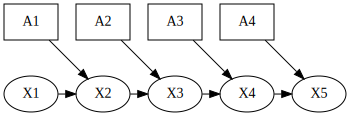

In [26]:
markovChain = gtsam.DiscreteBayesNet()
for k in reversed(range(1,N)):
    markovChain.add(X[k+1], [X[k], A[k]], vacuum.action_spec)
show(markovChain, hints={"A":2, "X":1, "Z":0}, boxes={A[k][0] for k in range(1,N)})

In [27]:
def perform_rollout(x1, actions):
    """Roll out states given actions as a dictionary"""
    dict = actions.copy()
    dict[X[1]] = x1
    given = VARIABLES.assignment(dict)
    return markovChain.sample(given)

To execute a specific rollout for the control tape R,U,L,L, we can use the following code:

In [28]:
actions = {A[1]:"R", A[2]:"U", A[3]:"L", A[4]:"L"}
rollout = perform_rollout("Office", actions)
pretty(rollout)

Variable,value
A1,R
A2,U
A3,L
A4,L
X1,Office
X2,Office
X3,Office
X4,Office
X5,Office


It is important to remember that any individual rollout corresponds to a sample trajectory from a stochastic process.
If you execute the above code several times, you should observe that the robot does not always arrive to the living room.

The code below executes the rollout and computes the corresponding utility for the sample trajectory.
Sample trajectories that do not arrive to the living room will have zero utility.

In [29]:
def reward(rollout, k):
    """Return state, action, next_state triple for given rollout at time k."""
    state = rollout[X[k][0]]
    action = rollout[A[k][0]]
    next_state = rollout[X[k+1][0]]
    return R[state, action, next_state]

def rollout_reward(rollout, horizon=N, gamma=1.0):
    """Calculate reward for a given rollout"""
    discounted_rewards = [gamma**(k-1) * reward(rollout,k) for k in range(1,horizon)]
    return sum(discounted_rewards)
    
print(rollout_reward(rollout))

0.0


The following code executes 20 rollouts for the action sequence R,U,L,L, and prints the utility for each sample trajectory.
You can see that in many cases the robot fails to arrive to the living room (thus earning zero utility)!
This is because each of the first two actions have a 0.2 probability of failure, and if either of these fail, the robot is unable to reach the living room using this control tape.

In [70]:
def control_tape_reward(x1, actions):
    """Calculate reward given a dictionary of actions"""
    rollout = perform_rollout(x1, actions)
    return rollout_reward(rollout)

print([control_tape_reward("Office", actions) for i in range(20)])

[30.0, 0.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 0.0, 30.0, 0.0, 0.0, 30.0, 30.0, 30.0, 0.0, 30.0, 30.0]


Finally, the expected utility of the action sequence R,U,L,L simply averages over all 20 rollouts:

In [71]:
np.mean([control_tape_reward("Office", actions) for i in range(20)])

19.5

### Exercises:
- Execute both cells above multiple times and observe the effect.
- The rewards above seems to be always either zero or 30. Why is that?

## Policies

> A policy is a function that specifies which action to take in each state.

In the example above, the control tape rollout for the action sequence R,U,L,L failed many times.
The reason for this failure may seem obvious: the robot executed the same sequence of actions,
regardless of the state trajectory.
If the robot had been able to choose its actions based on the current state,
it would have chosen to move right until it reached the hallway,
at which time it would have chosen to move up until reaching the living room.
Clearly, the robot would make better choices if it were allowed to dynamically
choose which action to execute based on its current state.

A **policy**, $\pi: {\cal X} \rightarrow {\cal A}$ is a mapping from states to actions.
Specifying a policy instead of a control tape has the potential to significantly improve the robot's performance, by adapting the action sequence based on the actual state trajectory that occurs during execution.

The code below defines a fairly intuitive policy. If in the office, move right. If in the dining room or kitchen, move left.
If in the hallway or living room, move up.
Note we implement policies as a simple list in python, so `pi[0]` is the the action take in state with index 0 (the Living Room):

In [31]:
RIGHT = vacuum.action_space.index("R")
LEFT  = vacuum.action_space.index("L")
UP    = vacuum.action_space.index("U")
DOWN  = vacuum.action_space.index("D")

reasonable_policy = [UP, LEFT, RIGHT, UP, LEFT]

Again, we return an index into the `action_space` to make the following code efficient. 
Once we have a given policy, $\pi$, we can compute a policy rollout in a manner analogous to computing
control tape rollouts described above.
In particular, at each state, instead of sampling from the distribution
$P(X_{t+1} | a_t, X_t)$ we sample from the distribution
$P(X_{t+1} | \pi(X_t), X_t)$. In other words, instead of simulating a pre-specified action $a_t$, we choose $a_t = \pi(X_t)$.

Here is a function that computes a rollout given a policy, rather than a control tape:

In [32]:
def policy_rollout(x1, pi, horizon=N):
    """Roll out states given a policy pi, for given horizon."""
    rollout = gtsam.DiscreteValues()
    x = x1
    for k in range(1, horizon):
        a = pi[x]
        rollout[X[k][0]] = x
        rollout[A[k][0]] = a
        next_state_distribution = gtsam.DiscreteDistribution(X[k+1], T[x, a])
        x = next_state_distribution.sample()
    rollout[X[horizon][0]] = x
    return rollout

pretty(policy_rollout(vacuum.rooms.index("Office"), reasonable_policy, horizon=5))

Variable,value
A1,R
A2,U
A3,U
A4,U
X1,Office
X2,Hallway
X3,Living Room
X4,Living Room
X5,Living Room


Above, we proposed two methods to plan an action sequence,
a greedy approach that maximizes the expected reward for executing a single action,
and an optimization-based method that chooses a fixed action sequence to maximize the
expected utility of the action sequence.
We described how to implement the computations required for the latter approach using control tape rollouts.

With the introduction of policies, planning is reduced to the search for an appropriate
policy.
In the best case, this policy would maximize the expected utility with respect to the policy.
Because policies are state-dependent, the combinatorics of enumerating all possible
policies precludes any approach that attempts to explicitly enumerate candidate policies.
Instead, we will focus on methods that explore the utility associated to
a policy.
As we will now see, this is somewhat more complicated than exploring the utility
for a fixed sequence of actions.

## The Value Function (for a given policy)
> The value function $V^\pi$ measures the expected outcome from each state, under a given policy $\pi$.

Above, we defined the utility for a specific sequence of $n$ actions as

$$
U(a_1, \dots, a_n, x_1, \dots x_{n+1}) =
R(x_1,a_1, x_2) + \gamma R(x_2, a_2, x_3) + \gamma^2 R(x_3, \pi(x_3), x_4) + \dots \gamma^{n} R(x_{n}, a_{n}, x_{n+1})$$

and used the expected utility, $E[U(a_1, \dots, a_n, X_1, \dots X_n)]$ as a quantitative measure
of the efficacy of the specific action sequence.
We can apply this same type of reasoning for a policy, $\pi$.
When evaluating policies, it is typical to use a discounted
reward over an infinite time horizon.
In this case, we define the **value function for policy $\pi$**,
$V^\pi:{\cal X} \rightarrow \mathbb{R}$ as


$$
V^\pi(x_1) \doteq E [R(x_1, \pi(x_1), X_2) + \gamma R(X_2, \pi(X_2), X_3) + \gamma^2 R(X_3, \pi(X_3), X_4) + \dots]
$$

where the expectation is taken over the possible values
of the states $X_2, X_2, X_3 \dots$.
Note that the policy $\pi$ is deterministic, but that $\pi(X_i)$ is the random action that results
from applying the deterministic policy to the stochastic state $X_i$.

In the definition for $V^\pi$, the argument is given as $x_1$, the initial state.
We can easily generalize this to arbitrary time steps as

$$
V^\pi(x_t) \doteq E [R(x_t, \pi(x_t), X_{t+1}) + \gamma R(X_{t+1}, \pi(X_{t+1}), X_{t+2}) + \gamma^2 R(X_{t+2}, \pi(X_{t+2}), X_{t+3}) + \dots]
$$

The value function for a policy can be written in a nice recursive form
that can be obtained by the following derivation.

$$
\begin{align*}
V^\pi(x_1) &=
E [R(x_1, \pi(x_1), X_2) + \gamma R(X_2, \pi(X_2), X_3) + \gamma^2 R(X_3, \pi(X_3), X_4) + \dots] \\
&=
 \sum_{x_2} P(x_2|x_1, \pi(x_1)) \{R(x_1, \pi(x_1), x_2) + E [\gamma R(x_2, \pi(x_2), X_3) + \gamma^2 R(X_3, \pi(X_3), X_4) + \dots]\}\\
&= \sum_{x_2} P(x_2|x_1, \pi(x_1)) \{R(x_1, \pi(x_1), x_2) + \gamma V^\pi(x_2)\}
\end{align*}
$$

where the second line is obtained by explicitly writing the summation for the expectation
taken with respect to the random state $X_2$,
and the third line is obtained by noticing that
$V^\pi(x_2) =E [\gamma R(x_2, \pi(x_2), X_3) + \gamma^2 R(X_3, \pi(X_3), X_4) + \dots]$.

We can apply the distributivity property to this expression to obtain

$$
\begin{align*}
V^\pi(x_1) &= \sum_{x_2} P(x_2|x_1, \pi(x_1)) R(x_1, \pi(x_1), x_2) + \gamma  \sum_{x_2} P(x_2|x_1, \pi(x_1))  V^\pi(x_2) \\
&= \bar{R}(x_1,\pi(x_1)) + \gamma \sum_{x_2} P(x_2|x_1, \pi(x_1)) V^\pi(x_2)
\end{align*}
$$
 
in which the term $\bar{R}(x_1,\pi(x_1))$ is the expected reward for applying action $a = \pi(x_1)$ in state $x_1$.
This can be computed directly using the reward function and transition probabilities.
By now substituting $x$ for $x_1$, and $x'$ for $x_{2}$ we can generalize this expression
to apply to the state $x$ at any arbitrary time:

$$V^\pi(x) = \bar{R}(x,\pi(x)) + \gamma \sum_{x'} P(x'|x, \pi(x)) V^\pi(x')$$

This has a very nice interpretation: the value of a state under a given policy is the expected reward $\bar{R}(x,\pi(x))$ under that policy, *plus* the discounted expected value of the next state.

### Thought exercise

 Without a discount factor, we would always be hopeful that if we take one more step, we will find a pot of gold. Reflect on what various values for the discount factor mean in real life.

## Approximating the Value Function

> We can use rollouts to approximate the value function as well.

Just as we approximated the expected utility of an action sequence
using control tape rollouts,
we can approximate the value function by sampling over a number of policy rollouts.
This process provides a *Monte Carlo approximation* of the value function for a given policy. 
Of course we cannot apply a policy rollout over an infinite time horizon, so we apply
the rollout only to some finite number of time steps, say $N_{\rm{ro}}$.

Note this is an approximation in *two* ways: 
1. We approximate the expectation by averaging over $N_{\rm{Samples}}$ sample trajectories.
2. We only roll out for  $N_{\rm{ro}}$ steps.
We can improve on this by increasing the number of samples or by increasing the horizon, but at a cost linear in their product, i.e., 
$O(N_{\rm{ro}} N_{\rm{Samples}})$:

You might worry that evaluating sample paths of length $N_{\rm{ro}}$ could lead to significant errors
in our approximation.
In fact, it is easy to determine an upper bound on this error.
Since $R(x, a, x') $ is finite,
we know that there is some upper bound $R_{\rm{max}}$ such that $R(x, a, x') < R_{\rm{max}}$, for all
possible $x,a,x'$.
We can use this fact to find a bound on $V^\pi$:

$$V^\pi(x_t)
\leq \max_{x_t, x_{t+1}, \dots} \sum_{i=0}^\infty \gamma ^i R(x_{t+i},\pi(x_{t+i}), x_{t+i+1})
\leq \sum_{i=0}^\infty \gamma ^i R_{\rm{max}} = \frac{R_{\rm{max}}}{1 - \gamma}$$

in which the final term applies for $0 < \gamma < 1$.
This expression can then be used to bound the error 

$$
V^\pi(x) - \sum_{i=0}^{N_{\rm{ro}}}\gamma ^i R(x_i,\pi(xi), x_{i+1})$$

Because we have functions to sample a policy rollout *and* to calculate the value of a rollout, the code is simple enough:

In [33]:
def approximate_value_function(x1, pi, nr_samples=10, horizon=N, gamma=0.9):
    """ Approximate the value function by performing `nr_samples` rollouts 
        starting from x1, and averaging the result.
    """
    rollouts = [policy_rollout(x1, pi, horizon) for _ in range(nr_samples)]
    rewards = [rollout_reward(rollout, horizon, gamma) for rollout in rollouts]
    return sum(rewards)/nr_samples

nr_samples=10
for x1, room in enumerate(vacuum.rooms):
    V_x1 = approximate_value_function(x1, reasonable_policy, nr_samples)
    print(f"V({room}) ~ {V_x1:.2f}")

V(Living Room) ~ 34.39
V(Kitchen) ~ 29.68
V(Office) ~ 20.88
V(Hallway) ~ 27.59
V(Dining Room) ~ 15.83


The above calculation was done with a horizon of $N=5$ and 10 samples. Of course, we can use more samples and a longer horizon to obtain a much more accurate estimate:

In [34]:
nr_samples = 100
horizon = 50
X = VARIABLES.discrete_series('X', range(1, horizon+1), vacuum.rooms)
A = VARIABLES.discrete_series('A', range(1, horizon), vacuum.action_space)
for x1, room in enumerate(vacuum.rooms):
    V_x1 = approximate_value_function(x1, reasonable_policy, nr_samples, horizon)
    print(f"V({room}) ~ {V_x1:.2f}")

V(Living Room) ~ 99.43
V(Kitchen) ~ 97.25
V(Office) ~ 84.82
V(Hallway) ~ 97.37
V(Dining Room) ~ 86.13


## Computing The Value Function*

> For any fixed policy we can *exactly* compute the value function.

We can compute the exact value of $V^\pi$ by solving a system of linear equations.
Recall our recursive definition of the value function:

$$V^\pi(x) = \bar{R}(x,\pi(x)) + \gamma \sum_{x'} P(x'|x, \pi(x)) V^\pi(x')$$

This equation holds for every possible value $x$ for the state.
Hence, if there are $n$ possible states, we obtain $n$ linear equations in $n$ unknowns.
Each of these $n$ equations is obtained by evaluating $V^\pi(x)$ for a specific value of $x$.
Collecting the unknown $V^\pi$ terms on the left hand side and the known $\bar{R}(x,\pi(x))$ 
terms on the right hand side, we obtain

$$V^\pi(x) - \gamma \sum_{x'} P(x'|x, \pi(x)) V^\pi(x') = \bar{R}(x,\pi(x))$$

 
To make this explicit yet concise for our vacuum cleaning robot example,
let us define the *scalar* $T^\pi_{xy}\doteq P(y|x,\pi(x))$ as the transition probability from state $x$ to state $y$ under policy $\pi$. 
In addition, we use the abbreviations L,K,O,H, and D for the rooms, and use the shorthand $V^\pi_x\doteq V^\pi(x)$ for the value of state $x$ under policy $\pi$. 
Using this notation, we can evaluate the above expression for 
r $x = L$, we obtain

$$ 
\begin{align*}
V^\pi(L) - \gamma \sum_{x'\in {L,K,O,H,D}} T^\pi_{Lx'} V^\pi_{x'} & = \bar{R}(L,\pi(L)) \\
V^\pi_{L}
- \gamma T^\pi_{LL} V^\pi_{L}
- \gamma T^\pi_{LK} V^\pi_{K} 
- \gamma T^\pi_{LO} V^\pi_{O} 
- \gamma T^\pi_{LH} V^\pi_{H} 
- \gamma T^\pi_{LD} V^\pi_{D} 
&= \bar{R}(L,\pi(L)) \\
(1 - \gamma T^\pi_{LL}) V^\pi_{L}
- \gamma T^\pi_{LK} V^\pi_{K} 
- \gamma T^\pi_{LO} V^\pi_{O} 
- \gamma T^\pi_{LH} V^\pi_{H} 
- \gamma T^\pi_{LD} V^\pi_{D} 
&= \bar{R}(L,\pi(L))
\end{align*}
$$

If we apply this same process for each of the five rooms,
we obtain the following five equations:


$$
\begin{align*}
(1 - \gamma T^\pi_{LL}) V^\pi_{L}
- \gamma T^\pi_{LK} V^\pi_{K} 
- \gamma T^\pi_{LO} V^\pi_{O} 
- \gamma T^\pi_{LH} V^\pi_{H} 
- \gamma T^\pi_{LD} V^\pi_{D} 
&= \bar{R}(L,\pi(L))
\\
- \gamma T^\pi_{KL} V^\pi_{L}
+ (1 - \gamma T^\pi_{KK}) V^\pi_{K} 
- \gamma T^\pi_{KO} V^\pi_{O} 
- \gamma T^\pi_{KH} V^\pi_{H} 
- \gamma T^\pi_{KD} V^\pi_{D} 
&= \bar{R}(K,\pi(K))
\\
- \gamma T^\pi_{OL} V^\pi_{L}
- \gamma T^\pi_{OK} V^\pi_{K} 
+ (1 - \gamma T^\pi_{OO}) V^\pi_{O} 
- \gamma T^\pi_{OH} V^\pi_{H} 
- \gamma T^\pi_{OD} V^\pi_{D} 
&= \bar{R}(O,\pi(O))
\\
- \gamma T^\pi_{HL} V^\pi_{L}
- \gamma T^\pi_{HK} V^\pi_{K} 
- \gamma T^\pi_{HO} V^\pi_{O} 
+ (1 - \gamma T^\pi_{HH}) V^\pi_{H} 
- \gamma T^\pi_{HD} V^\pi_{D} 
&= \bar{R}(H,\pi(H))
\\
- \gamma T^\pi_{DL} V^\pi_{L}
- \gamma T^\pi_{DK} V^\pi_{K} 
- \gamma T^\pi_{DO} V^\pi_{O} 
- \gamma T^\pi_{DH} V^\pi_{H} 
+ (1 - \gamma T^\pi_{DD}) V^\pi_{D} 
&= \bar{R}(D,\pi(D))
\end{align*}
$$

The unknowns in these equations are 
$V^\pi_{L}, V^\pi_{K}, V^\pi_{O}, V^\pi_{H}, V^\pi_{D}$. All of the other terms are
either transition probabilities or expected rewards, whose values are either given,
or can easily be computed.

In code, this becomes:

In [35]:
def calculate_value_system(pi, gamma=0.9):
    """Calculate A, b matrix of linear system for value computation."""
    b = np.empty((5,), float)
    AA = np.empty((5,5), float)
    for x, room in enumerate(vacuum.rooms):
        a = pi[x] # action under policy
        b[x] = T[x,a] @ R[x,a] # expected reward under policy pi
        AA[x] = -gamma * T[x,a]
        AA[x,x] += 1
    return AA,b
    
def calculate_value_function(pi, gamma=0.9):
    """Calculate value function for given policy"""
    AA, b = calculate_value_system(pi, gamma)
    return np.linalg.solve(AA,b)

Here is the linear system for the policy `reasonable_policy` (which is really almost always wrong):

In [79]:
AA, b = calculate_value_system(reasonable_policy)
print(f"A =\n{AA}")
print(f"b = {b}")

A =
[[ 0.1  -0.   -0.   -0.   -0.  ]
 [-0.72  0.82 -0.   -0.   -0.  ]
 [-0.   -0.    0.82 -0.72 -0.  ]
 [-0.72 -0.   -0.    0.82 -0.  ]
 [-0.   -0.   -0.   -0.72  0.82]]
b = [10.  8.  0.  8.  0.]


When we calculate the value function $V^\pi$ under this policy `reasonable_policy` we see that our *exact* value function was well approximated by Monte Carlo estimate above:

In [37]:
value_for_pi = calculate_value_function(reasonable_policy)
print("V(reasonable_policy):")
for i,room in enumerate(vacuum.rooms):
    print(f"  {room:12}: {value_for_pi[i]:.2f}")

V(reasonable_policy):
  Living Room : 100.00
  Kitchen     : 97.56
  Office      : 85.66
  Hallway     : 97.56
  Dining Room : 85.66


#### Exercise

Why is the value function in the living room $100$ and not the immediate reward $10$?

## Optimal Policy and Value Function

> The optimal policy and optimal value function are besties.

Now that we know how to compute the value function for an arbitrary policy $\pi$,
we turn our attention to computing the **optimal value function**,
which can be used to construct the **optimal policy** $\pi^*$

The optimal value function  $V^*: {\cal X} \rightarrow {\cal A}$
is merely the value function for the optimal policy.
This can be written mathmatically as

$$
\begin{align*}
V^*(x) &= \max_\pi V^{\pi}(x) \\
&=
\max_\pi \left\{ \bar{R}(x,\pi(x)) + \gamma \sum_{x'} P(x'|x, \pi(x)) V^\pi(x')   \right\}\\
&=
\max_a  \left\{ \bar{R}(x,a) + \gamma \sum_{x'} P(x'|x, a) V^*(x')   \right\} \\
\end{align*}
$$

In the above, the second line follows immediately by substituting
our earlier expression for $V^\pi$ into the maximization.
The third line is more interesting.
Because the value function has been written in recursive form,
$\pi$ is only applied to the current state (i.e., when $\pi$ is evaluated in the optimization,
it always appears as $\pi(x)$).
Therefore, we can write the optimization
as a maximization with respect to the *action* applied in the *current state*, rather than as a
maximization with respect to the entire policy $\pi$!
This equation is known as the **Bellman equation**.
It is named after Richard Bellman, the mathematician
who discovered it, and it is one of the most important equations in all of computer science.

The Bellman equation has a very nice interpretation: 
the optimal value function of a state is the maximum expected reward 
*plus* the discounted expected value function when acting optimally in the future.

Using Bellman's equation, it is straightforward to compute the optimal policy from a given state.

$$
\pi^*(x) = \arg
\max_a  \left\{ \bar{R}(x,a) + \gamma \sum_{x'} P(x'|x, a) V^*(x')   \right\} 
$$

This computation is performed so often that it is convenient to introduce the so-called $Q$-function

$$
\begin{align*}
Q^*(x,a) \doteq \bar{R}(x,a) + \gamma \sum_{x'} P(x'|x, a) V^*(x') 
\end{align*}
$$

which allows us to write the optimal policy as


$$
\pi^*(x) = \arg
\max_a  Q^*(x,a)
$$

We will see the $Q$-function again, when we discuss reinforcement learning.
The code for computing a Q-value from a value function is given below:

In [38]:
def Q_value(value_function, x, a, gamma=0.9):
    """Calculate Q(x,a) from given value function"""
    return T[x,a] @ (R[x,a] + gamma * value_function)

We will describe two methods for determining the optimal policy.
The first method, policy iteration, iteratively improves candidate policies,
ultimately converging to the optimal policy $\pi^*$.
The second method, value iteration, iteratively improves an estimate of $V^*$,
ultimately converging to the optimal value function.

## Policy Iteration

> By iteratively improving an estimate of the optimal policy, we eventually find $\pi^*$.

One way to compute an optimal policy is to start with an initial guess
at the optimal policy, and then iteratively improve our guess until until no futher improvements are possible.
This is exactly the approach taken by **policy iteration**.
In particular, policy iteration generates a sequence of policies
$\pi^0, \pi^1, \dots \pi^n$, such that $\pi^{k+1}$ is better than policy $\pi^k$.
This process ends when no further improvement is possible, which
occurs when $\pi^{k+1} = \pi^k.$

To improve the policy $\pi^k$, we update the action chosen *for each state* by applying
Bellman's equation using $\pi^k$ in place of $\pi^*$.
The can be achieved with the following algorithm:

Start with a random policy $\pi^0$, and repeat until convergence:
1. Compute the value function $V^{\pi^k}$
2. Improve the policy for each state $x \in {\cal X}$ using the update rule: 
$\pi^{k+1}(x) \leftarrow\arg \max_a \sum_{x'} \{P(x'|x, a) \{R(x, a, x') + \gamma V^k(x')\}$

Notice that this algorithm has the side benefit of computing 
successively better approximations to the value function at each iteration.
Because there are a finite number of actions that can be applied ini each state, there are only finitely many ways to update
a policy. Therefore, we expect this policy iteration algorithm to converge in finite time.

We already know how to do step one, via `calculate_value_function`. The second step of the algorithm is easily
implemented with the following code:

In [39]:
def update_policy(value_function):
    """Update policy given a value function"""
    new_policy = [None for _ in range(5)]
    for x, room in enumerate(vacuum.rooms):
        Q_values = [Q_value(value_function, x, a) for a in range(4)]
        new_policy[x] = np.argmax(Q_values)
    return new_policy

The whole policy iteration algorithm then simply iterates these until the policy no longer changes. If no initial policy is given, we can
start with a zero value function
$V^{\pi^0}(x) = 0$ for all $x$:

In [82]:
def policy_iteration(pi=None, max_iterations=100):
    """Do policy iteration, starting from policy `pi`."""
    for _ in range(max_iterations):
        value_for_pi = calculate_value_function(pi) if pi is not None else np.zeros((5,))
        new_policy = update_policy(value_for_pi)
        if new_policy == pi:
            return pi, value_for_pi
        pi = new_policy
    raise RuntimeError("No stable policy found after {max_iterations} iterations")

On the other hand, if we have a guess for the initial policy, we can intialize
$\pi^0$ accordingly.
For example, we can start with a not-so-smart `always_right` policy:

In [80]:
RIGHT = vacuum.action_space.index("R")

always_right = [RIGHT, RIGHT, RIGHT, RIGHT, RIGHT]

In [42]:
optimal_policy, optimal_value_function = policy_iteration(always_right)
print([vacuum.action_space[a] for a in optimal_policy])

['L', 'L', 'R', 'U', 'U']


Starting with the `always_right` policy, our policy iteration algorithm converges to an
intuitively pleasing policy.
In the dining room and kitchen we go `left`, in the office we go `right`, and in the hallway and dining room we go `up`.
This is significantly different from the `always_right` policy (which might be better named `almost_always_wrong`).
In fact, it is exactly the `reasonable_policy` that we created above.
We already knew that it should be pretty good at getting to the living room as fast as possible. In fact, it is optimal!

We also print out the optimal value function below, which shows that if we are close to the living room the value function is very high, but it is a bit lower in the office in the dining room:

In [43]:
for i,room in enumerate(vacuum.rooms):
    print(f"  {room:12}: {optimal_value_function[i]:.2f}")

  Living Room : 100.00
  Kitchen     : 97.56
  Office      : 85.66
  Hallway     : 97.56
  Dining Room : 85.66


The optimal policy is also obtained when we start without a policy, starting with a zero value function:

In [44]:
optimal_policy, _ = policy_iteration()
print([vacuum.action_space[a] for a in optimal_policy])


['L', 'L', 'R', 'U', 'U']


Just be sure, let us sanity check the solution above using the Monte Carlo estimate of the policy, which should give the same answer:

In [45]:
nr_samples = 100
horizon = 100
X = VARIABLES.discrete_series('X', range(1, horizon+1), vacuum.rooms)
A = VARIABLES.discrete_series('A', range(1, horizon), vacuum.action_space)
for x1, room in enumerate(vacuum.rooms):
    V_x1 = approximate_value_function(x1, optimal_policy, nr_samples, horizon)
    print(f"V({room}) ~ {V_x1:.2f}")

V(Living Room) ~ 100.00
V(Kitchen) ~ 98.03
V(Office) ~ 84.55
V(Hallway) ~ 97.48
V(Dining Room) ~ 85.91


These values are remarkably similar to the exact values computed above!

## Value Iteration

> Dynamic programming can be used to obtain the optimal value function.

Recall Bellman's equation, which must hold for each state $x$.

$$
V^*(x) = \max_a  \left\{ \bar{R}(x,a) + \gamma \sum_{x'} P(x'|x, a) V^*(x')   \right\} 
$$

Sadly, this is not a linear equation (the maximimation operation is not linear), so we cannot solve this
equation for $V^*$ as a system of linear equations.
**Value iteration** approximates $V^*$ by constructing a sequence of estimates,
$V^0, V^1, \dots , V^n$ that converges to $V^*$.
Starting with an initial guess, $V^0$, at each iteration we update
our approximation of the value function by the update rule:

$$
V^{k+1}(x) \leftarrow \max_a \left\{ \bar{R}(x,a) + \gamma \sum_{x'} P(x'|x, a) V^k(x')   \right\} 
$$

Notice that the right hand side of includes two terms:
the expected reward (which we can compute exactly), and a term in $V^k$ (our current best guess at the value function).
Value iteration operates by iteratively using our *current best guess* of $V^*$ along with the *known* expected reward
to update the approximation.
Unlike policy iteration, we do not expect value iteration to converge to the exact result in finite time.
Therefore, we cannot use $V^{k+1} = V^k$ as our termination condition.
Instead, we often use a condition such as $|V^{k+1} - V^k| < \epsilon$, for some small value of $\epsilon$
as the termination condition.

Finally, note that we can define Q values for the $k^{th}$ iteration as
$$
Q(x, a; V^k) \doteq \bar{R}(x,a) + \gamma \sum_{x'} P(x'|x, a) V^k(x'),
$$

and hence a value update is simply
$$
V^{k+1}(x) \leftarrow \max_a Q(x, a; V^k).
$$



In code, this is actually easier than policy iteration:

In [46]:
V_k = np.full((5,), 100)
for k in range(10):
    Q_k = np.sum(T * (R + 0.9 * V_k), axis=2) # 5 x 4
    V_k = np.max(Q_k, axis=1) # max over actions
    print(np.round(V_k,2))

[100.  98.  90.  98.  90.]
[100.    97.64  86.76  97.64  86.76]
[100.    97.58  85.92  97.58  85.92]
[100.    97.56  85.72  97.56  85.72]
[100.    97.56  85.68  97.56  85.68]
[100.    97.56  85.67  97.56  85.67]
[100.    97.56  85.66  97.56  85.66]
[100.    97.56  85.66  97.56  85.66]
[100.    97.56  85.66  97.56  85.66]
[100.    97.56  85.66  97.56  85.66]


Compare with optimal value function:

In [47]:
print(np.round(optimal_value_function, 2))

[100.    97.56  85.66  97.56  85.66]


And we can easily *extract* the optimal policy:

In [48]:
Q_k = np.sum(T * (R + 0.9 * V_k), axis=2)
pi_k = np.argmax(Q_k, axis=1)
print(f"policy = {pi_k}")
print([vacuum.action_space[a] for a in pi_k])

policy = [0 0 1 2 0]
['L', 'L', 'R', 'U', 'L']


## Summary

Markov Decion Processes or MDPs are used to model decision in a stochastic environment, albeit with complete knowledge of the state. It is a rich subject, and we introduced many new concepts in this section:

- The reward function $R : {\cal X} \times {\cal A} \times {\cal X} \rightarrow \mathbb{R}$.
- The expected reward $\bar{R}(x,a)$ for executing action $a$ in state $x$, and the corresponding greedy planning algorithm.
- The utility function $U: {\cal A}^n \times {\cal X}^{n+1} \rightarrow \mathbb{R}$ as the sum of discounted rewards.
- The notion of rollouts to approximate the expected utility of actions.
- The policy $\pi: {\cal X} \rightarrow {\cal A}$ as a mapping from states to actions.
- the value function $V^\pi:{\cal X} \rightarrow \mathbb{R}$ associated with a given policy $\pi$.
- The use of policy rollouts to approximate the value function $V^\pi$.
- Exact calculation of the value function for a fixed policy.
- The optimal policy and value function, governed by the Bellman equation.
- Two algorithms to compute those: policy iteration and value iteration.

There are two important extensions to MDPs that are not covered in this section:

- Partially Observable MDPs (or POMDPS) are appropriate when we cannot directly observe the state. We will not cover these in this book.
- Reinforcement learning, a way to learn MDP policies from *data*. This will be covered next. 